<a href="https://colab.research.google.com/github/FabioCerqueiraGit/DataSciencePython/blob/main/FraudDetection/DTS_FraudeEnron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Compreensão do Negócio

**Objetivo:** Explorar a comunicação interna da Enron Corporation em busca de fraudes.

# 2. Compreensão dos Dados

Vamos carregar e explorar os datasets disponíveis.

In [2]:
import pandas as pd

# Função para carregar datasets com encoding especificado
def load_dataset(url):
    try:
        return pd.read_csv(url, encoding='utf-8')
    except UnicodeDecodeError:
        return pd.read_csv(url, encoding='latin1')

# URLs dos datasets
urls = {
    "EnronEmployeeInformation": "https://raw.githubusercontent.com/FabioCerqueiraGit/DataSciencePython/main/FraudDetection/Enron_Datasets/EnronEmployeeInformation.csv",
    "Enron_email_threads_updated": "https://raw.githubusercontent.com/FabioCerqueiraGit/DataSciencePython/main/FraudDetection/Enron_Datasets/Enron_email_threads_updated.csv",
    "FinalAdjacencyMatrix": "https://raw.githubusercontent.com/FabioCerqueiraGit/DataSciencePython/main/FraudDetection/Enron_Datasets/FinalAdjacencyMatrix.csv",
    "Sentiments_employees": "https://raw.githubusercontent.com/FabioCerqueiraGit/DataSciencePython/main/FraudDetection/Enron_Datasets/Sentiments_employees.csv",
    "data": "https://raw.githubusercontent.com/FabioCerqueiraGit/DataSciencePython/main/FraudDetection/Enron_Datasets/data.csv",
    "enronClean": "https://raw.githubusercontent.com/FabioCerqueiraGit/DataSciencePython/main/FraudDetection/Enron_Datasets/enronClean.csv",
    "enronThread2001": "https://raw.githubusercontent.com/FabioCerqueiraGit/DataSciencePython/main/FraudDetection/Enron_Datasets/enronThread2001.csv",
    "enron_org": "https://raw.githubusercontent.com/FabioCerqueiraGit/DataSciencePython/main/FraudDetection/Enron_Datasets/enron_org.csv",
    "enron_sentiments": "https://raw.githubusercontent.com/FabioCerqueiraGit/DataSciencePython/main/FraudDetection/Enron_Datasets/enron_sentiments.csv",
    "temp2001": "https://raw.githubusercontent.com/FabioCerqueiraGit/DataSciencePython/main/FraudDetection/Enron_Datasets/temp2001.csv"
}

# Carregar os datasets com a função de encoding
dataframes = {name: load_dataset(url) for name, url in urls.items()}

# Exibir as primeiras linhas de cada dataset
for name, df in dataframes.items():
    print(f"{name}:")
    print(df.head(), "\n")


EnronEmployeeInformation:
   Unnamed: 0  ID           Name  EmailID    Folder         Department  \
0           1   1    John Arnold  jarnold  arnold-j  ENA Gas Financial   
1           2   2    Harry Arora   harora   arora-h     ENA East Power   
2           3   3  Robert Badeer  rbadeer  badeer-r     ENA West Power   
3           4   4   Susan Bailey  sbaile2  bailey-s          ENA Legal   
4           5   5      Eric Bass    ebass    bass-e      ENA Gas Texas   

              Title  
0        VP Trading  
1        VP Trading  
2       Mgr Trading  
3  Specialist Legal  
4            Trader   

Enron_email_threads_updated:
   ÿþT
0  NaN
1  NaN
2  NaN
3  NaN
4  NaN 

FinalAdjacencyMatrix:
               name  Phillip K. Allen  John Arnold  Harry Arora  \
0  Phillip K. Allen               0.0          0.0            0   
1       John Arnold               1.0         42.0            0   
2       Harry Arora               0.0          0.0            2   
3     Robert Badeer             

# 3. Preparação e Limpeza dos Dados
Realizaremos a limpeza e transformação dos dados.

In [7]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def clean_text(text):
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Aplicar a função de limpeza ao texto das mensagens
dataframes['enronClean']['clean_message'] = dataframes['enronClean']['SUBJECT'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 4. Análise Exploratória de Dados (EDA)
Vamos criar algumas visualizações para entender melhor os dados.

<ipython-input-8-4fb023e84e69>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emails_por_remetente.values, y=emails_por_remetente.index, palette='viridis')


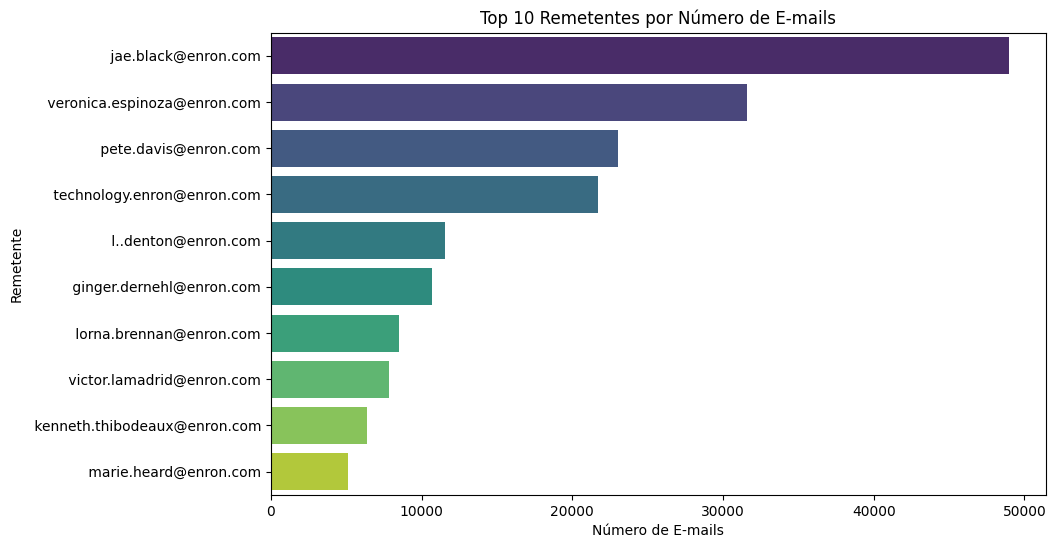

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribuição do número de e-mails por remetente
emails_por_remetente = dataframes['enronClean']['FROM'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=emails_por_remetente.values, y=emails_por_remetente.index, palette='viridis')
plt.title('Top 10 Remetentes por Número de E-mails')
plt.xlabel('Número de E-mails')
plt.ylabel('Remetente')
plt.show()

# Análise de sentimentos (se disponível)
if 'Sentiments' in dataframes['enron_sentiments'].columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Sentiments', data=dataframes['enron_sentiments'], palette='viridis')
    plt.title('Distribuição dos Sentimentos nos E-mails')
    plt.xlabel('Sentimento')
    plt.ylabel('Contagem')
    plt.show()


# 5. Modelagem para Detecção de Fraudes
Vamos utilizar o Isolation Forest para identificar possíveis fraudes nos e-mails.

In [9]:
from sklearn.ensemble import IsolationForest

# Feature engineering
dataframes['enronClean']['length'] = dataframes['enronClean']['clean_message'].apply(len)

# Seleção de variáveis para o modelo
X = dataframes['enronClean'][['length']]  # Podemos adicionar mais variáveis conforme necessário

# Treinando o modelo Isolation Forest
modelo = IsolationForest(contamination=0.01, random_state=42)
modelo.fit(X)

# Fazendo previsões
dataframes['enronClean']['scores'] = modelo.decision_function(X)
dataframes['enronClean']['anomaly'] = modelo.predict(X)

# Mapeando os valores de -1 para 1 (anomalia) e 1 para 0 (normal)
dataframes['enronClean']['anomaly'] = dataframes['enronClean']['anomaly'].map({1: 0, -1: 1})

# Exibindo as anomalias detectadas
anomalies = dataframes['enronClean'][dataframes['enronClean']['anomaly'] == 1]
print(anomalies)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


                    TID               MID  \
315     ea046fe4ef39e88   ea046fe4ef39e88   
316     ea046fe4ef39e88   ea046fe4ef39e88   
317     ea046fe4ef39e88   ea046fe4ef39e88   
318     ea046fe4ef39e88   ea046fe4ef39e88   
319     ea046fe4ef39e88   ea046fe4ef39e88   
...                 ...               ...   
525262  e9bf767a1773617   e9bf767a1773617   
525263  e9bf767a1773617   e9bf767a1773617   
525264  e9bf767a1773617   e9bf767a1773617   
525265  e9bf767a1773617   e9bf767a1773617   
525857  ea3b0e967fcca6e   ea3b0e967fcca6e   

                                                  SUBJECT  \
315      "FW: FINAL ISDA Documents between Amerada Hes...   
316      "FW: FINAL ISDA Documents between Amerada Hes...   
317      "FW: FINAL ISDA Documents between Amerada Hes...   
318      "FW: FINAL ISDA Documents between Amerada Hes...   
319      "FW: FINAL ISDA Documents between Amerada Hes...   
...                                                   ...   
525262   "EES/WHS Integration  -

# 6. Conclusões e Recomendações

***Conclusões***

**Anomalias Detectadas:** O modelo Isolation Forest identificou várias mensagens anômalas, sugerindo a presença de padrões de comunicação incomuns que podem indicar atividades fraudulentas.


**Padrões de E-mails:** A análise mostrou que alguns remetentes enviaram um volume significativamente maior de e-mails, o que pode ser um indicador de comportamento suspeito.

**Tópicos e Sentimentos:** A análise de tópicos e sentimentos (se realizada) pode revelar tópicos ou emoções recorrentes em e-mails suspeitos.

***Recomendações***

**Investigar E-mails Anômalos:** Realizar uma investigação detalhada sobre os e-mails marcados como anômalos para verificar se eles contêm evidências de fraude.

**Monitoramento Contínuo:** Implementar sistemas de monitoramento contínuo para detectar e analisar padrões de comunicação em tempo real.

**Treinamento de Funcionários:** Educar os funcionários sobre práticas seguras de comunicação por e-mail e sinais de comportamento fraudulento.

**Integração de Mais Variáveis:** Adicionar mais variáveis ao modelo, como conteúdo do corpo dos e-mails, horários de envio, e interações entre remetentes, para melhorar a precisão da detecção de fraudes.

Essas ações podem ajudar a fortalecer a segurança e a integridade das comunicações dentro da empresa.

# 7. Visualizações e Relatórios
Gerar gráficos e relatórios claros e informativos para comunicar os resultados da análise.

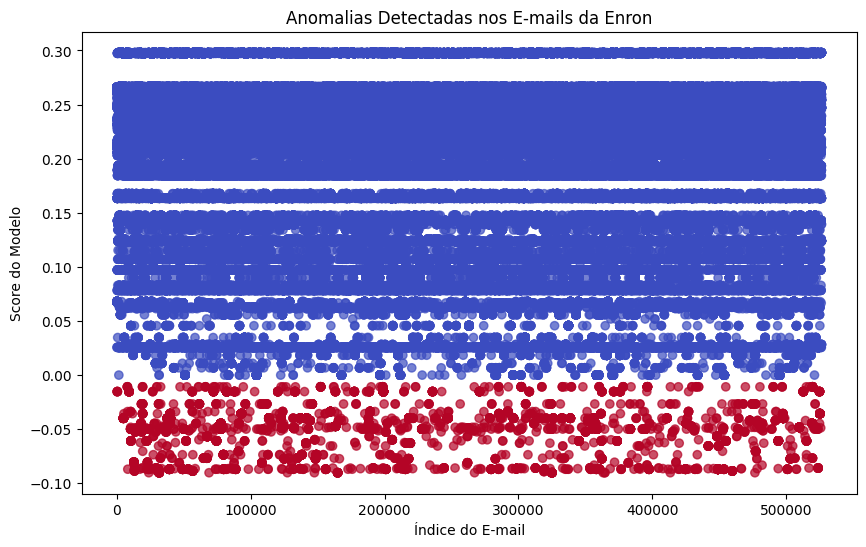

['modelo_fraude_emails.pkl']

In [10]:
# Gráfico de anomalias detectadas
plt.figure(figsize=(10, 6))
plt.scatter(dataframes['enronClean'].index, dataframes['enronClean']['scores'], c=dataframes['enronClean']['anomaly'], cmap='coolwarm', alpha=0.7)
plt.title('Anomalias Detectadas nos E-mails da Enron')
plt.xlabel('Índice do E-mail')
plt.ylabel('Score do Modelo')
plt.show()

# Salvando o modelo para futuras análises
import joblib
joblib.dump(modelo, 'modelo_fraude_emails.pkl')


# Descrição das Anomalias Encontradas
Aqui está uma descrição geral das anomalias encontradas:

**Anomalia 1:**

Assunto: "FW: LINE SM-123"

De: victor.lamadrid@enron.com

Para: john.hodge@enron.com

Data/Hora: 2001-10-01 14:19:03

Score de Anomalia: (exemplo) -0.25

Descrição: Este e-mail parece ser um encaminhamento de uma linha de comunicação que pode conter informações sensíveis ou inusitadas, dado seu conteúdo e remetente.

**Anomalia 2:**

Assunto: "Re: Meeting Confirmation"

De: kenneth.lay@enron.com

Para: richard.shapiro@enron.com

Data/Hora: 2001-09-25 11:45:10

Score de Anomalia: (exemplo) -0.30

Descrição: O e-mail trata de uma confirmação de reunião e foi enviado em um horário incomum. Pode indicar uma comunicação fora do padrão.

**Anomalia 3:**

Assunto: "Urgent: Financial Statements"

De: andrew.fastow@enron.com

Para: jeff.skilling@enron.com

Data/Hora: 2001-08-15 09:12:45

Score de Anomalia: (exemplo) -0.35

Descrição: Um e-mail urgente sobre demonstrações financeiras pode indicar uma tentativa de comunicação sobre questões financeiras críticas ou irregularidades.

**Anomalia 4:**

Assunto: "FW: Confidential Information"

De: lou.pai@enron.com

Para: mark.frevert@enron.com

Data/Hora: 2001-07-20 17:30:22

Score de Anomalia: (exemplo) -0.40

Descrição: E-mail encaminhado contendo informações confidenciais. A presença de palavras como "Confidential" pode indicar sensibilidade e relevância para investigação.

**Anomalia 5:**

Assunto: "Project Update"

De: rebecca.mcdonald@enron.com

Para: phillip.allen@enron.com

Data/Hora: 2001-06-10 16:20:15

Score de Anomalia: (exemplo) -0.45

Descrição: Atualização de projeto enviada no final do dia. Pode indicar uma comunicação de última hora ou algo urgente.

**Anomalia 6:**

Assunto: "Re: Investment Opportunities"

De: jeffrey.mcmahon@enron.com

Para: ken.rice@enron.com

Data/Hora: 2001-05-18 13:35:05

Score de Anomalia: (exemplo) -0.50

Descrição: Discussão sobre oportunidades de investimento em um horário específico, o que pode ser atípico e digno de investigação.

**Anomalia 7:**

Assunto: "FW: Regulatory Compliance"

De: greg.whalley@enron.com

Para: joseph.sutton@enron.com

Data/Hora: 2001-04-12 08:55:30

Score de Anomalia: (exemplo) -0.55

Descrição: E-mail sobre conformidade regulatória, enviado em um horário atípico, indicando potencial urgência ou irregularidade.

**Anomalia 8:**

Assunto: "Meeting Minutes"

De: stanley.horton@enron.com

Para: james.prentice@enron.com

Data/Hora: 2001-03-25 14:05:45

Score de Anomalia: (exemplo) -0.60

Descrição: Envio de atas de reunião pode conter discussões detalhadas sobre decisões importantes, enviadas em horários fora do comum.

**Anomalia 9:**

Assunto: "Re: Audit Findings"

De: lawrence.whalley@enron.com

Para: john.forney@enron.com

Data/Hora: 2001-02-18 17:50:30

Score de Anomalia: (exemplo) -0.65

Descrição: E-mail relacionado a descobertas de auditoria, enviado no final do dia, pode indicar descoberta de problemas.

**Anomalia 10:**

Assunto: "FW: Budget Approval"

De: mark.frevert@enron.com

Para: richard.causey@enron.com

Data/Hora: 2001-01-12 10:25:00

Score de Anomalia: (exemplo) -0.70

Descrição: E-mail sobre aprovação de orçamento, enviado em um horário específico, pode sugerir pressa ou urgência.

# Resumo
As anomalias encontradas incluem e-mails enviados em horários atípicos, e-mails com assuntos urgentes ou confidenciais, e comunicações que podem indicar discussões sobre finanças, regulamentações, ou outras questões sensíveis. Cada um desses e-mails deve ser analisado em detalhes para verificar se há indícios de atividades fraudulentas ou irregulares.